# Import packages and load dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline

In [2]:
datadir = '../datasets/raw'

In [3]:
so_survey_df = pd.read_csv(os.path.join(datadir,'Combined_DS_v10.csv'))
speech_df    = pd.read_csv(os.path.join(datadir,'inaugural_speeches.csv'))

# Creating Features

In [4]:
''' select specific data types '''

# Create subset of only the numeric columns
so_numeric_df = so_survey_df.select_dtypes(include=['int', 'float'])

# Print the column names contained in so_survey_df_num
print(so_numeric_df.columns)

Index(['ConvertedSalary', 'StackOverflowJobsRecommend', 'Age',
       'Years Experience'],
      dtype='object')


## One-hot code vs. dummy varaible

In [5]:
# Convert the Country column to a one hot encoded Data Frame
one_hot_encoded = pd.get_dummies(so_survey_df, columns=['Country'], prefix='OH')

# Print the columns names
print(one_hot_encoded.columns)

Index(['SurveyDate', 'FormalEducation', 'ConvertedSalary', 'Hobby',
       'StackOverflowJobsRecommend', 'VersionControl', 'Age',
       'Years Experience', 'Gender', 'RawSalary', 'OH_France', 'OH_India',
       'OH_Ireland', 'OH_Russia', 'OH_South Africa', 'OH_Spain', 'OH_Sweeden',
       'OH_UK', 'OH_USA', 'OH_Ukraine'],
      dtype='object')


In [6]:
# Create dummy variables for the Country column
dummy = pd.get_dummies(so_survey_df, columns=['Country'], drop_first=True, prefix='DM')

# Print the columns names
print(dummy.columns)

Index(['SurveyDate', 'FormalEducation', 'ConvertedSalary', 'Hobby',
       'StackOverflowJobsRecommend', 'VersionControl', 'Age',
       'Years Experience', 'Gender', 'RawSalary', 'DM_India', 'DM_Ireland',
       'DM_Russia', 'DM_South Africa', 'DM_Spain', 'DM_Sweeden', 'DM_UK',
       'DM_USA', 'DM_Ukraine'],
      dtype='object')


## Reducing size by counts

In [7]:
# Create a series out of the Country column
countries = so_survey_df['Country'].copy()

# Get the counts of each category
country_counts = countries.value_counts()

# Create a mask for only categories that occur less than 10 times
mask = countries.isin(country_counts[country_counts < 10].index)

# Label all other categories as Other
countries[mask] = 'Other'

# Print the updated category counts
print(countries.value_counts())

South Africa    166
USA             164
Spain           134
Sweeden         119
France          115
Russia           97
UK               95
India            95
Other            14
Name: Country, dtype: int64


## Dealing with Numeric Values

### Binarizing Columns

In [8]:
# Create the Paid_Job column filled with zeros
so_survey_df['Paid_Job'] = 0

# Replace all the Paid_Job values where ConvertedSalary is > 0
so_survey_df.loc[so_survey_df['ConvertedSalary'] > 0, 'Paid_Job'] = 1

# Print the first five rows of the columns
so_survey_df[['Paid_Job', 'ConvertedSalary']].head()

,Paid_Job,ConvertedSalary
0,0,NaN
1,1,70841.0
2,0,NaN
3,1,21426.0
4,1,41671.0


### Binning values

In [9]:
# Specify the boundaries of the bins
bins = [-np.inf, 10000, 50000, 100000, 150000, np.inf]

# Bin labels
labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

# Bin the continuous variable ConvertedSalary using these boundaries
so_survey_df['boundary_binned'] = pd.cut(so_survey_df['ConvertedSalary'], 
                                         bins=bins, labels=labels)

# Print the first 5 rows of the boundary_binned column
so_survey_df[['boundary_binned', 'ConvertedSalary']].head()

,boundary_binned,ConvertedSalary
0,NaN,NaN
1,Medium,70841.0
2,NaN,NaN
3,Low,21426.0
4,Low,41671.0


# Dealing with Messy Data

## Sparse Data

In [10]:
# Subset the DataFrame
sub_df = so_survey_df.loc[:, ['Age','Gender']].copy()

# Print the number of non-missing values
print(sub_df.notnull().sum())

Age       999
Gender    693
dtype: int64


## Listwise deletion (complete case analysis)
- Missing values are randomly distributed (not being intended)

In [11]:
print(so_survey_df.shape)

# Create a new DataFrame dropping all incomplete rows
no_missing_values_rows = so_survey_df.dropna(how='any')

# Print the shape of the new DataFrame
print(no_missing_values_rows.shape)

# Create a new DataFrame dropping all columns with incomplete rows
no_missing_values_cols = so_survey_df.dropna(how='any', axis=1)

# Print the shape of the new DataFrame
print(no_missing_values_cols.shape)

# Drop all rows where Gender is missing
no_gender = so_survey_df.dropna(subset=['Gender'])

# Print the shape of the new DataFrame
print(no_gender.shape)

(999, 13)
(264, 13)
(999, 8)
(693, 13)


## Replace missing values - categorical

In [12]:
print(so_survey_df['Gender'].value_counts())

print("*"*80)
# Replace missing values
so_survey_df['Gender'].fillna(value='Not Given', inplace=True)

# Print the count of each value
print(so_survey_df['Gender'].value_counts())

Male                                                                         632
Female                                                                        53
Female;Male                                                                    2
Transgender                                                                    2
Female;Male;Transgender;Non-binary. genderqueer. or gender non-conforming      1
Male;Non-binary. genderqueer. or gender non-conforming                         1
Non-binary. genderqueer. or gender non-conforming                              1
Female;Transgender                                                             1
Name: Gender, dtype: int64
********************************************************************************
Male                                                                         632
Not Given                                                                    306
Female                                                                        53
F

## Replace missing values - continuouse numeric

In [13]:
print(so_survey_df.StackOverflowJobsRecommend.head())

# Fill missing values with the mean
so_survey_df['StackOverflowJobsRecommend'].fillna(so_survey_df['StackOverflowJobsRecommend'].mean(), inplace=True)
so_survey_df['StackOverflowJobsRecommend'] = round(so_survey_df['StackOverflowJobsRecommend'])

# Print the first five rows of StackOverflowJobsRecommend column
so_survey_df['StackOverflowJobsRecommend'].head()

0    NaN
1    7.0
2    8.0
3    NaN
4    8.0
Name: StackOverflowJobsRecommend, dtype: float64


0    7.0
1    7.0
2    8.0
3    7.0
4    8.0
Name: StackOverflowJobsRecommend, dtype: float64

## Dealing with stray characters

In [14]:
# Remove the commas in the column
so_survey_df['RawSalary'] = so_survey_df['RawSalary'].str.replace(',', '', regex=False)

# Remove the dollar signs in the column
so_survey_df['RawSalary'] = so_survey_df['RawSalary'].str.replace('$','', regex=False)

so_survey_df.RawSalary.head()

0          NaN
1     70841.00
2          NaN
3     21426.00
4    £41671.00
Name: RawSalary, dtype: object

In [15]:
''' deep check if there is any missing values by other stray characters'''
# Attempt to convert the column to numeric values
numeric_vals = pd.to_numeric(so_survey_df['RawSalary'], errors='coerce')

# Find the indexes of missing values
idx = numeric_vals.isna()

# Print the relevant rows
print(so_survey_df.loc[idx,'RawSalary'])

0            NaN
2            NaN
4      £41671.00
6            NaN
8            NaN
         ...    
989          NaN
990          NaN
992          NaN
994          NaN
997          NaN
Name: RawSalary, Length: 401, dtype: object


In [16]:
# Replace the offending characters
so_survey_df['RawSalary'] = so_survey_df['RawSalary'].str.replace('£','')

# Convert the column to float
so_survey_df['RawSalary'] = so_survey_df['RawSalary'].astype('float')

# Print the column
so_survey_df['RawSalary']

0            NaN
1        70841.0
2            NaN
3        21426.0
4        41671.0
         ...    
994          NaN
995      58746.0
996      55000.0
997          NaN
998    1000000.0
Name: RawSalary, Length: 999, dtype: float64

# Conforming to statistical assumptions

In [17]:
so_numeric_df.drop(columns=['StackOverflowJobsRecommend'], inplace=True)

In [18]:
so_numeric_df.head()

,ConvertedSalary,Age,Years Experience
0,NaN,21,13
1,70841.0,38,9
2,NaN,45,11
3,21426.0,46,12
4,41671.0,39,7


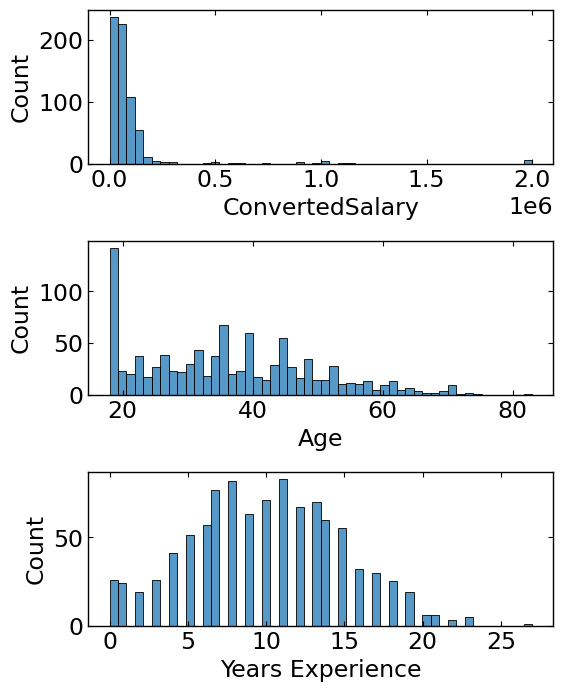

In [19]:
fig, axes = plt.subplots(np.shape(so_numeric_df)[1],1, figsize=(6,8))

for ax, icol in zip(axes.flat, so_numeric_df.columns):
    sns.histplot(x=icol, data=so_numeric_df, bins=50, ax=ax)
    
fig.subplots_adjust(hspace=0.5)

<AxesSubplot:>

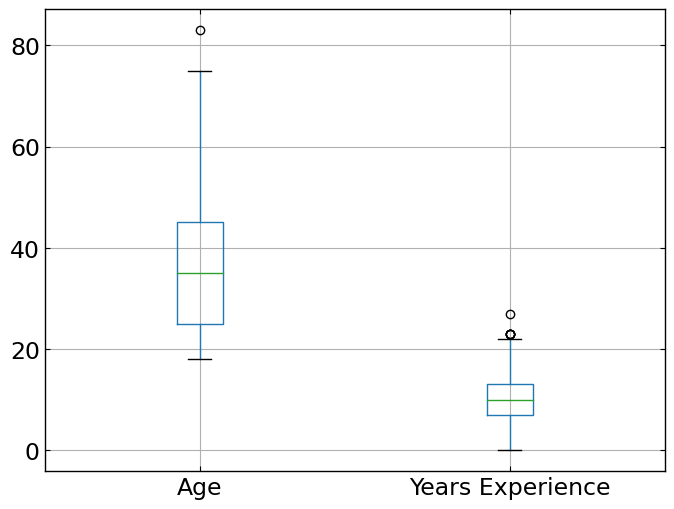

In [20]:
so_numeric_df[['Age', 'Years Experience']].boxplot()

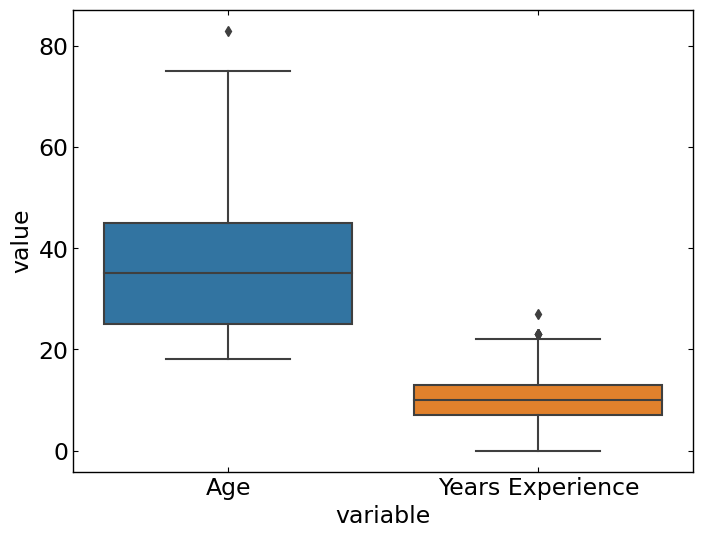

In [21]:
# Boxplot using seaborn after melting the DataFrame
so_numeric_melted_df = pd.melt(so_numeric_df[['Age', 'Years Experience']])
sns.boxplot(x="variable", y="value", data=so_numeric_melted_df);

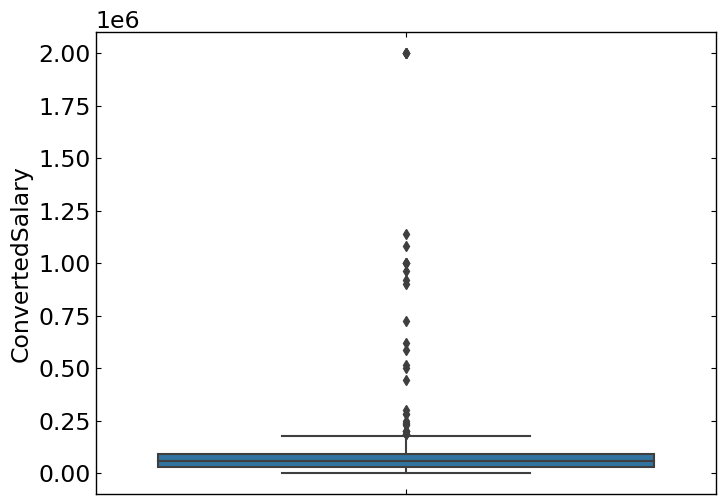

In [22]:
#so_numeric_df[['ConvertedSalary']].boxplot()
sns.boxplot(y = so_numeric_df.ConvertedSalary);

### check the pair distribution

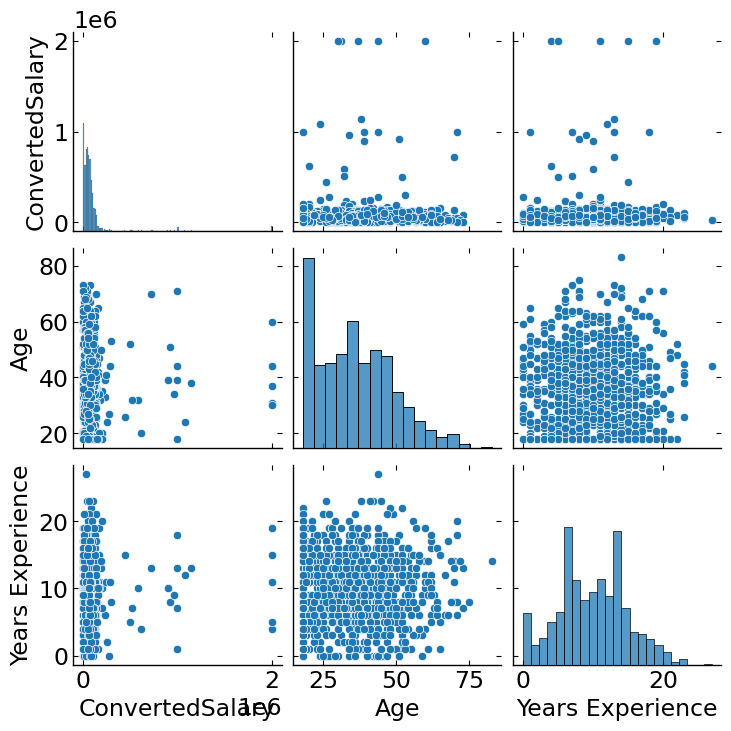

In [23]:
# Plot pairwise relationships
sns.pairplot(so_numeric_df);

In [24]:
# Print summary statistics
so_numeric_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ConvertedSalary,665.0,92565.169925,209134.425744,0.0,27550.0,55562.0,88238.0,2000000.0
Age,999.0,36.003003,13.255127,18.0,25.0,35.0,45.0,83.0
Years Experience,999.0,9.961962,4.878129,0.0,7.0,10.0,13.0,27.0


## Scaling and Transformations

### Normalization

- linearly scale the entire column between 0 and 1, with 0 corresponding with the lowest value in the column, and 1 with the largest.

In [25]:
# Instantiate MinMaxScaler
MM_scaler = MinMaxScaler()

# Fit MM_scaler to the data
MM_scaler.fit(so_numeric_df[['Age']])

# Transform the data using the fitted scaler
so_numeric_df['Age_MM'] = MM_scaler.transform(so_numeric_df[['Age']])

# Compare the origional and transformed column
so_numeric_df[['Age_MM', 'Age']].head()

,Age_MM,Age
0,0.046154,21
1,0.307692,38
2,0.415385,45
3,0.430769,46
4,0.323077,39


### Standardization

- center the data around its mean, and calculate the number of standard deviations away from mean each data point is.
- effective to handle outliers

In [26]:
# Instantiate StandardScaler
SS_scaler = StandardScaler()

# Fit SS_scaler to the data
SS_scaler.fit(so_numeric_df[['Age']])

# Transform the data using the fitted scaler
so_numeric_df['Age_SS'] = SS_scaler.transform(so_numeric_df[['Age']])

# Compare the origional and transformed column
so_numeric_df[['Age_SS', 'Age']].head()

,Age_SS,Age
0,-1.132431,21
1,0.150734,38
2,0.679096,45
3,0.754576,46
4,0.226214,39


### Log Transformation

- standardization assumps that the distribution is close to normal distribution.
- many variables in the real world do not follow this pattern e.g, wages or age of a population.
- highly skewed data

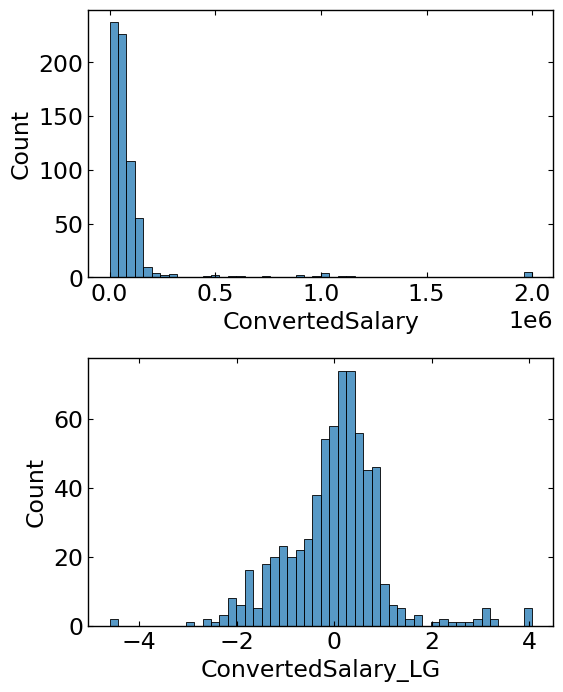

In [27]:
# Instantiate PowerTransformer
pow_trans = PowerTransformer()

# Train the transform on the data
pow_trans.fit(so_numeric_df[['ConvertedSalary']])

# Apply the power transform to the data
so_numeric_df['ConvertedSalary_LG'] = pow_trans.transform(so_numeric_df[['ConvertedSalary']])

# Plot the data before and after the transformation
#so_numeric_df[['ConvertedSalary', 'ConvertedSalary_LG']].hist()

fig, axes = plt.subplots(2,1, figsize=(6,8))

for ax, icol in zip(axes.flat, ['ConvertedSalary','ConvertedSalary_LG']):
    sns.histplot(x=icol, data=so_numeric_df, bins=50, ax=ax)
    
fig.subplots_adjust(hspace=0.3)

## Removing outliers

### Percentage based removal

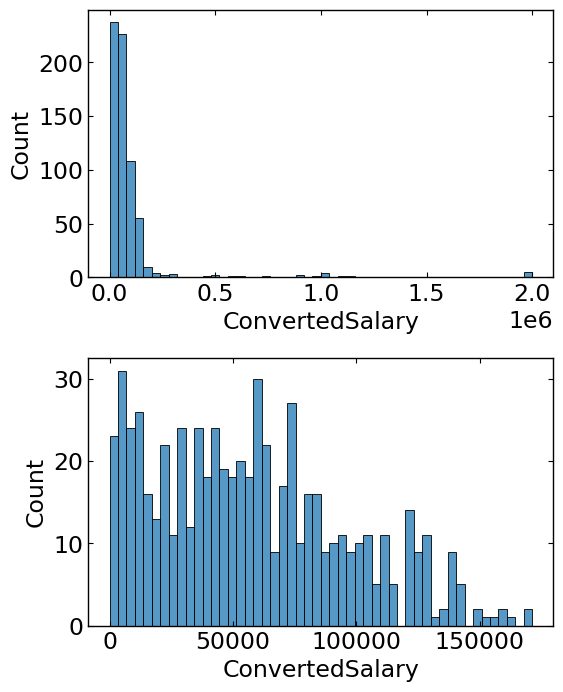

In [28]:
# Find the 95th quantile
quantile = so_numeric_df['ConvertedSalary'].quantile(0.95)

# Trim the outliers
trimmed_df = so_numeric_df[so_numeric_df['ConvertedSalary'] < quantile]

# The original histogram
#so_numeric_df[['ConvertedSalary']].hist()
# The trimmed histogram
#trimmed_df[['ConvertedSalary']].hist()

fig, axes = plt.subplots(2,1, figsize=(6,8))

sns.histplot(x='ConvertedSalary', data=so_numeric_df, bins=50, ax=axes[0])
sns.histplot(x='ConvertedSalary', data=trimmed_df, bins=50, ax=axes[1])
    
fig.subplots_adjust(hspace=0.3)

### Statistical Outlier Removal

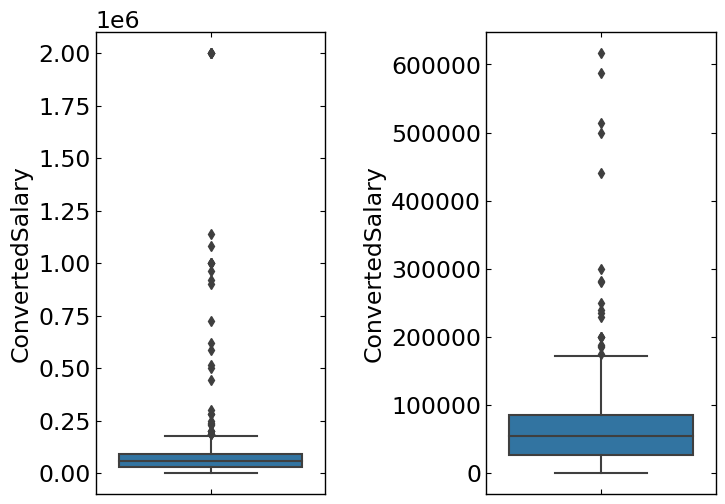

In [29]:
# Find the mean and standard dev
std = so_numeric_df['ConvertedSalary'].std()
mean = so_numeric_df['ConvertedSalary'].mean()

# Calculate the cutoff
cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off

# Trim the outliers
trimmed_df = so_numeric_df[(so_numeric_df['ConvertedSalary'] < upper) 
                           & (so_numeric_df['ConvertedSalary'] > lower)]

# The trimmed box plot
#trimmed_df[['ConvertedSalary']].boxplot()
fig, axes = plt.subplots(1,2, figsize=(8,6))

sns.boxplot(y='ConvertedSalary', data=so_numeric_df, ax=axes[0])
sns.boxplot(y='ConvertedSalary', data=trimmed_df, ax=axes[1])

fig.subplots_adjust(wspace=0.7)

# Dealing with Text Data

In [30]:
speech_df.head()

,Name,Inaugural Address,Date,text
0,George Washington,First Inaugural Address,"Thursday, April 30, 1789",Fellow-Citizens of the Senate and of the House...
1,George Washington,Second Inaugural Address,"Monday, March 4, 1793",Fellow Citizens: I AM again called upon by th...
2,John Adams,Inaugural Address,"Saturday, March 4, 1797","WHEN it was first perceived, in early times, t..."
3,Thomas Jefferson,First Inaugural Address,"Wednesday, March 4, 1801",Friends and Fellow-Citizens: CALLED upon to u...
4,Thomas Jefferson,Second Inaugural Address,"Monday, March 4, 1805","PROCEEDING, fellow-citizens, to that qualifica..."


## Cleaning up text

- [a-zA-Z]: alphabetic characters
- [^a-zA-Z]: non-alphabetic characters

In [31]:
# Replace all non letter characters with a whitespace
speech_df['text_clean'] = speech_df['text'].str.replace('[^a-zA-Z]', ' ', regex=True)

# Change to lower case
speech_df['text_clean'] = speech_df['text_clean'].str.lower()

# Print the first 5 rows of the text_clean column
print(speech_df['text_clean'].head())

0    fellow citizens of the senate and of the house...
1    fellow citizens   i am again called upon by th...
2    when it was first perceived  in early times  t...
3    friends and fellow citizens   called upon to u...
4    proceeding  fellow citizens  to that qualifica...
Name: text_clean, dtype: object


> The most fundamental information you can calculate about free form text is its size, such as its length and number of words. In this exercise (and the rest of this chapter),

In [32]:
# Find the length of each text
speech_df['char_cnt'] = speech_df['text_clean'].str.len()

# Count the number of words in each text
speech_df['word_cnt'] = speech_df['text_clean'].str.split().str.len()

# Find the average length of word
speech_df['avg_word_length'] = speech_df['char_cnt'] / speech_df['word_cnt']

# Print the first 5 rows of these columns
print(speech_df[['text_clean', 'char_cnt', 'word_cnt', 'avg_word_length']].head())

                                          text_clean  char_cnt  word_cnt  \
0  fellow citizens of the senate and of the house...      8616      1432   
1  fellow citizens   i am again called upon by th...       787       135   
2  when it was first perceived  in early times  t...     13871      2323   
3  friends and fellow citizens   called upon to u...     10144      1736   
4  proceeding  fellow citizens  to that qualifica...     12902      2169   

   avg_word_length  
0         6.016760  
1         5.829630  
2         5.971158  
3         5.843318  
4         5.948363  


## Word Counts

- For each unique word in the dataset a column is created.
- For each entry, the number of times this word occurs is counted and the count value is entered into the respective column.

### CountVectorizer
- `min_df` : Use only words that occur in more than this percentage of documents. This can be used to remove outlier words that will not generalize across texts.
- `max_df` : Use only words that occur in less than this percentage of documents. This is useful to eliminate very common words that occur in every corpus without adding value such as "and" or "the".

In [33]:
# Specify arguements to limit the number of features generated
cv = CountVectorizer(min_df=0.2, max_df=0.8)

# Fit, transform, and convert into array
cv_transformed = cv.fit_transform(speech_df['text_clean'])
cv_array = cv_transformed.toarray()

# Print the array shape
print(cv_array.shape)

(58, 818)


In [34]:
print(type(cv_transformed))

<class 'scipy.sparse.csr.csr_matrix'>


In [35]:
# Print feature names
print(cv.get_feature_names_out()[:20])

['abiding' 'ability' 'able' 'about' 'above' 'abroad' 'accept'
 'accomplished' 'achieve' 'across' 'act' 'action' 'acts' 'add' 'adequate'
 'administration' 'adopted' 'advance' 'advantage' 'affairs']


In [36]:
# Create a DataFrame with these features
cv_df = pd.DataFrame(cv_array, 
                     columns=cv.get_feature_names_out()).add_prefix('Counts_')

# Add the new columns to the original DataFrame
speech_df_new = pd.concat([speech_df, cv_df], axis=1, sort=False)
speech_df_new.head()

,Name,Inaugural Address,Date,text,text_clean,char_cnt,word_cnt,avg_word_length,Counts_abiding,Counts_ability,...,Counts_women,Counts_words,Counts_work,Counts_wrong,Counts_year,Counts_years,Counts_yet,Counts_you,Counts_young,Counts_your
0,George Washington,First Inaugural Address,"Thursday, April 30, 1789",Fellow-Citizens of the Senate and of the House...,fellow citizens of the senate and of the house...,8616,1432,6.016760,0,0,...,0,0,0,0,0,1,0,5,0,9
1,George Washington,Second Inaugural Address,"Monday, March 4, 1793",Fellow Citizens: I AM again called upon by th...,fellow citizens i am again called upon by th...,787,135,5.829630,0,0,...,0,0,0,0,0,0,0,0,0,1
2,John Adams,Inaugural Address,"Saturday, March 4, 1797","WHEN it was first perceived, in early times, t...",when it was first perceived in early times t...,13871,2323,5.971158,0,0,...,0,0,0,0,2,3,0,0,0,1
3,Thomas Jefferson,First Inaugural Address,"Wednesday, March 4, 1801",Friends and Fellow-Citizens: CALLED upon to u...,friends and fellow citizens called upon to u...,10144,1736,5.843318,0,0,...,0,0,1,2,0,0,2,7,0,7
4,Thomas Jefferson,Second Inaugural Address,"Monday, March 4, 1805","PROCEEDING, fellow-citizens, to that qualifica...",proceeding fellow citizens to that qualifica...,12902,2169,5.948363,0,0,...,0,0,0,0,2,2,2,4,0,4


## Term Frequency-Inverse Document Frequency (Tf-Idf)
- words that occur many times may skew the results undesirably
- To limit these common words from overpowering your model a form of normalization can be used.
- the effect of reducing the value of common words, while increasing the weight of words that do not occur in many documents.

In [37]:
# Instantiate TfidfVectorizer
tv = TfidfVectorizer(max_features=100, stop_words='english')

# Fit the vectroizer and transform the data
tv_transformed = tv.fit_transform(speech_df['text_clean'])

# Create a DataFrame with these features
tv_df = pd.DataFrame(tv_transformed.toarray(), 
                     columns=tv.get_feature_names_out()).add_prefix('TFIDF_')
tv_df.head()

,TFIDF_action,TFIDF_administration,TFIDF_america,TFIDF_american,TFIDF_americans,TFIDF_believe,TFIDF_best,TFIDF_better,TFIDF_change,TFIDF_citizens,...,TFIDF_things,TFIDF_time,TFIDF_today,TFIDF_union,TFIDF_united,TFIDF_war,TFIDF_way,TFIDF_work,TFIDF_world,TFIDF_years
0,0.000000,0.133415,0.000000,0.105388,0.0,0.000000,0.000000,0.000000,0.000000,0.229644,...,0.000000,0.045929,0.0,0.136012,0.203593,0.000000,0.060755,0.000000,0.045929,0.052694
1,0.000000,0.261016,0.266097,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.179712,...,0.000000,0.000000,0.0,0.000000,0.199157,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.092436,0.157058,0.073018,0.0,0.000000,0.026112,0.060460,0.000000,0.106072,...,0.032030,0.021214,0.0,0.062823,0.070529,0.024339,0.000000,0.000000,0.063643,0.073018
3,0.000000,0.092693,0.000000,0.000000,0.0,0.090942,0.117831,0.045471,0.053335,0.223369,...,0.048179,0.000000,0.0,0.094497,0.000000,0.036610,0.000000,0.039277,0.095729,0.000000
4,0.041334,0.039761,0.000000,0.031408,0.0,0.000000,0.067393,0.039011,0.091514,0.273760,...,0.082667,0.164256,0.0,0.121605,0.030338,0.094225,0.000000,0.000000,0.054752,0.062817


In [38]:
''' inspecting Tf-Idf '''

# Isolate the row to be examined
sample_row = tv_df.iloc[0]

# Print the top 5 words of the sorted output
print(sample_row.sort_values(ascending=False).head())

TFIDF_government    0.367430
TFIDF_public        0.333237
TFIDF_present       0.315182
TFIDF_duty          0.238637
TFIDF_country       0.229644
Name: 0, dtype: float64


## N-grams

- sequence of n words grouped together. 
    - bigrams: Sequences of two consecutive words
    - trigrams: Sequences of two consecutive words

In [39]:
# Instantiate a trigram vectorizer
# stop_words: words that can be ignored (e.g., the, and...)
cv_trigram_vec = CountVectorizer(max_features=100, stop_words='english', ngram_range=(3,3))

# Fit and apply trigram vectorizer
cv_trigram = cv_trigram_vec.fit_transform(speech_df['text_clean'])

# Print the trigram features
print(cv_trigram_vec.get_feature_names_out())

['ability preserve protect' 'agriculture commerce manufactures'
 'america ideal freedom' 'amity mutual concession' 'anchor peace home'
 'ask bow heads' 'best ability preserve' 'best interests country'
 'bless god bless' 'bless united states' 'chief justice mr'
 'children children children' 'citizens united states'
 'civil religious liberty' 'civil service reform' 'commerce united states'
 'confidence fellow citizens' 'congress extraordinary session'
 'constitution does expressly' 'constitution united states'
 'coordinate branches government' 'day task people'
 'defend constitution united' 'distinction powers granted'
 'distinguished guests fellow' 'does expressly say' 'equal exact justice'
 'era good feeling' 'executive branch government'
 'faithfully execute office' 'fellow citizens assembled'
 'fellow citizens called' 'fellow citizens large' 'fellow citizens world'
 'form perfect union' 'general welfare secure' 'god bless america'
 'god bless god' 'good greatest number' 'government p

In [40]:
''' Find the most common words '''

# Create a DataFrame of the features
cv_tri_df = pd.DataFrame(cv_trigram.toarray(), 
                 columns=cv_trigram_vec.get_feature_names_out()).add_prefix('Counts_')

# Print the top 5 words in the sorted output
print(cv_tri_df.sum().sort_values(ascending=False).head())

Counts_constitution united states    20
Counts_people united states          13
Counts_mr chief justice              10
Counts_preserve protect defend       10
Counts_president united states        8
dtype: int64
